# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print(labels.head(5))

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


Перед нами датасет, содержащий 7591 фотограцию и сведения о реальном возрасте запечатленных людей.

In [5]:
def load_data(labels):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, directory='/datasets/faces/final_files/', x_col='file_name',
        y_col='real_age', target_size=(224, 224), batch_size=32, class_mode='raw',
        seed=12345, subset='training')     
        
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels, directory='/datasets/faces/final_files/', x_col='file_name',
        y_col='real_age', target_size=(224, 224), batch_size=32, class_mode='raw',
        seed=12345, subset='validation')   
                                          
    return train_gen_flow, test_gen_flow

In [6]:
train_gen_flow, test_gen_flow = load_data(labels)

# Из обучающей выборки
x_train, y_train = next(train_gen_flow)
x_test, y_test = next(test_gen_flow)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [7]:
labels[['real_age']].describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


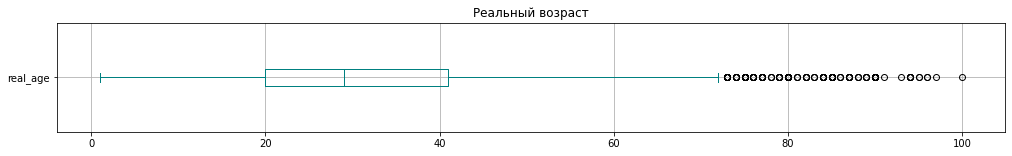

In [8]:
fig, ax = plt.subplots(figsize = (17,2))
ax = labels[['real_age']].boxplot(vert = False, ax =ax, color='teal')
ax.set_title('Реальный возраст');

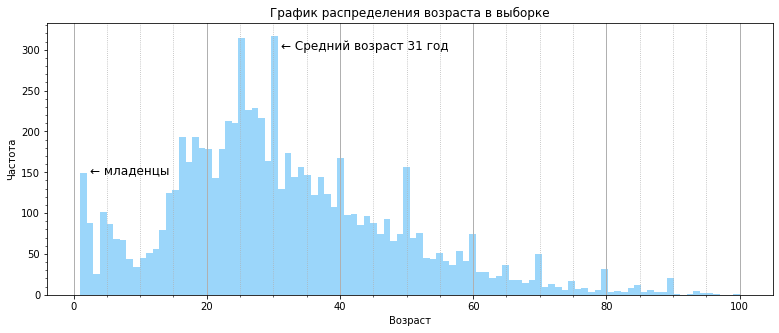

In [9]:
fig, ax = plt.subplots(figsize = (13,5))
data = labels.real_age
ax.hist(x=data, bins=100, color='#069AF3', alpha = 0.4)
ax.minorticks_on()
ax.grid(axis = 'x', which='major', linewidth = 1)
ax.grid(axis = 'x', which='minor', linestyle = ':')
ax.set_title('График распределения возраста в выборке')
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
# текстовые подписи
ax.text(x=2.5, y=148, s='← младенцы', fontsize='large')
ax.text(x=data.mean(), y=300, s='← Средний возраст 31 год', fontsize='large');

- Возраст людей на фотографиях от 1 до 100 лет.
- Средний возраст 31 год, медиана - 29 лет.
- Распределение перекошено вправо и содержит повторяющуюся аномалию: больше фотографий в возрасте кратном 10 (пики).

In [17]:
y_train

array([27, 19, 27,  6, 47, 25, 38, 50, 52,  7, 40, 50, 30, 60,  2, 39, 55,
       65, 51, 50, 10, 40,  1, 17, 30, 35, 61, 25, 48, 37, 43, 90])

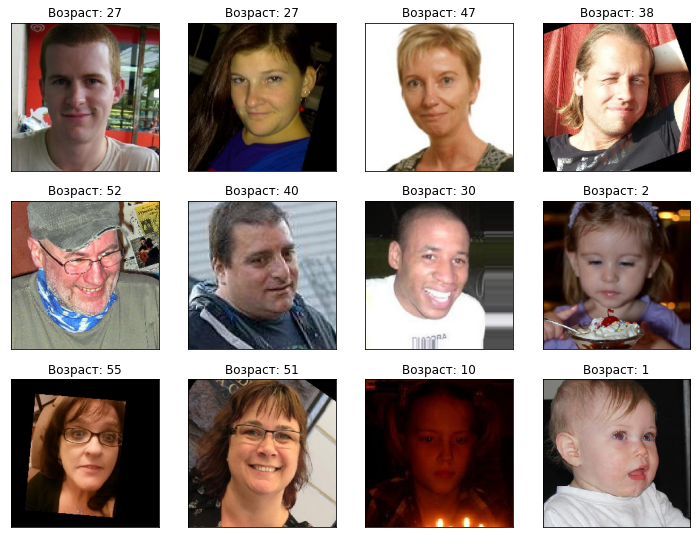

In [19]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(x_train[i*2])
    plt.title('Возраст: %s' % y_train[i*2])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- Целостность данных не нарушена: 7591 файл, столько же изображений и объектов в датафрейме;
- Фотографии лиц в профиль и анфас, принадлежат мужчинам и женщинам в возрасте от 0 до 100 лет;
- Средний возраст 31 год, фотографий молодых людей (20 - 41 год) больше;
- Похоже, что часть фотографий предварительно обработаны: голова вырезана и масштабирована, сделана попытка выравнивания позиции для каждой фотографии, но в некоторых случаях остался наклон. 
- Качество и формат неоднородны, есть чёрно-белые и цветные фото.

В процессе написания модели определения возраста мы учтем все сведения о имеющихся фотографиях:
- Используем методы простой аугментации: отражение по горизонтали.
- Перед нами задача регрессии, поэтому на выходе будет 1 нейрон, который вернёт предсказание возраста;
- В качестве функции активации возьмём ReLU, так как предсказываемый возраст не должен принимать отрицательные значения;

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError
 
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        vertical_flip=True)
     
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels, directory = '/datasets/faces/final_files/', 
        x_col='file_name', y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
        
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels, directory = '/datasets/faces/final_files/', 
        x_col='file_name', y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow

 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', 
                  metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data= test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size,
              verbose=2)
 
    return model 

```

```

60/60 - 10s - loss: 6.1290 - mae: 6.1496
Test MAE: 6.1496

```

## Анализ обученной модели

- Решалась задача регрессии, поэтому на выходе 1 нейрон, который возвращает предсказание возраста;
- Тип активации на последнем слое ReLU, так как предсказываемый возраст не должен принимать отрицательные значения;
- С целью увеличить датасет, выбраны методы аугментации подходящие для фото лиц: отражение по горизонтали и смещения по X,Y до 20%;
- В качестве CNN выбрана готовая архитектура ResNet50 в коробочной конфигурации;
- ResNet50 обучена на датасете imagenet, её необходимо лишь дообучить. Поэтому шаг обучения снижен на порядок Adam(lr=0.0001);
- 1/4 часть датасета отдана под валидацию, простая аугментация производилась только для обучающей выборки

**Итог:**

На 50 эпохе методом EarlyStopping с результатом предсказания MAE 6.1496;


Проведен эксперимент по аргументации:
   - при применении отражение по горизонтали и наклон фото на 20 градусов в обе сторону, качество предсказания модели MAE 7.1119 
   - при применении только отражение по горизонтали, качество предсказания  модели MAE 6.1496 


В среднем модель ошибается при определении возраста на 6 лет. Соответственно, данную модель можно использовать для разделения людей на возрастные группы, но не для точного определения возраста (магазины алкогольной продукции). Варианты использования:
- кинотеатры для определения возрастных предпочтений;
- магазины специфической продукции для определения возрастной целевой аудитории в рекламных целях (строительные материалы, бытовая химия, товары для взрослых и т.д.)
- массовые мероприятия для сбора статистики

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы